In [22]:
from datascience import *
from prob140 import *
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [23]:
def ks_plot(x_interval, sample, null_cdf):
    xmin = x_interval[0]
    xmax = x_interval[1]
    n=len(sample)
    sorted_sample = np.sort(sample)
    plt.step(sorted_sample, np.arange(1, n+1)/n, where='post', lw=2, 
             color='red', label='Empirical CDF of Sample')
    if sorted_sample.item(0) > xmin:
        plt.plot((xmin, sorted_sample.item(0), sorted_sample.item(0)), 
                 (0, 0, 1/n), lw=2, color='red')
    if sorted_sample.item(n-1) < xmax:
        plt.plot((sorted_sample.item(n-1), xmax), (1, 1), lw=2, color='red')
    x = np.arange(xmin, xmax+0.1, 0.1)
    plt.plot(x, null_cdf(x), lw=2, color='darkblue', label='Null CDF')
    plt.legend()
    print('n =', n);

def get_empirical_cdf(sample):
    def empirical_cdf(x):
        x = np.array(x)
        return np.mean(sample <= x.reshape(-1, 1), axis = 1)
    return empirical_cdf

# Worksheet 8 #

## 1. Chi-squared, `chi2`, and `chisquare`

**(a)** Recall that the chi-squared distribution with $n$ degrees of freedom is the same as gamma $(n/2, 1/2)$. Find its expectation, variance, and SD. Sometimes the expectation and SD by themselves give you a good sense of whether an observed statistic is consistent with a specified chi-squared distribution, without having to look up tail probabilities.

*The mean of the chi-squared distribution with $n$ degrees of freedom is $n$ and the variance is $4n$.*

**(b)** In `stats` within `scipy`, `chi2` works like `norm`, `expon`, etc. For example, `stats.chi2.pdf(x, df=d)` gives you the value of density function of the chi-squared (`d`) distribution at the point or array `x`. Plot the chi-squared $(4)$ density curve. Use Part **(a)** to figure out a good set of values for the horizontal axis.

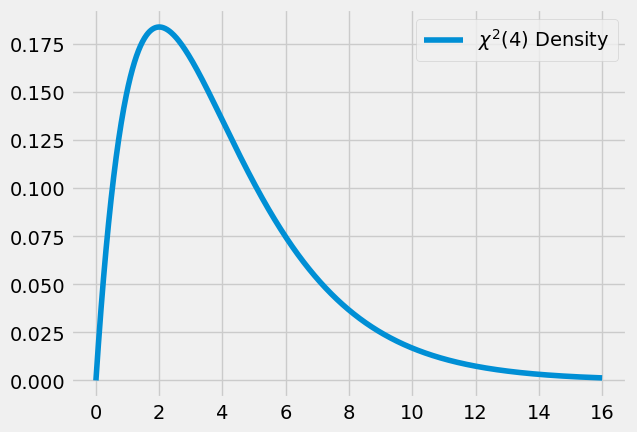

In [5]:
# Part (b)
xs = np.linspace(0, 16, 1001)
ys = stats.chi2.pdf(xs, df = 4)
plt.plot(xs, ys, label = r'$\chi^2(4)$ Density')
plt.legend()

**(c)** The [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html) for `stats.chisquare` says, "The chi-square test tests the null hypothesis that the categorical data has the given frequencies." A little more precisely, it tests the null hypothesis that the categorical data are like random draws from the given distribution. 

US jury panels are supposed to be picked at random from the eligible population. A [Data 8 example](https://inferentialthinking.com/chapters/11/2/Multiple_Categories.html#composition-of-panels-in-alameda-county) provides data on a panel of 1453 potential jurors in Alameda County. We have placed the data in the two arrays below. 

In [6]:
eligible = np.array([0.15, 0.18, 0.54, 0.12, 0.01])
panel = np.array([0.26, 0.08, 0.54, 0.08, 0.04])

Let's use a chi-squared statistic to assess whether the panel looks like random draws from the eligible population.

**(i)** Calculate Pearson's chi-squared statistic directly from the arrays and use Part **(a)** or **(b)** to come to a conclusion.

In [7]:
# Part (c)(i)
O = panel * 1453
E = eligible * 1453
sum((O - E)**2/E)

348.07422222222226

*Reject the null hypothesis, since that's a tiny $p$ value under the $\chi^2(4)$ distribution.*

**(ii)** Now use `stats.chisquare` to perform the test and compare the result with your calculation above. Think about whether you need to use the `ddof` option.

In [8]:
# Part (c)(ii)
stats.chisquare(O, E)

Power_divergenceResult(statistic=348.07422222222226, pvalue=4.568494800707335e-74)

*The calculated statistic is identical, and, as expected, the $p$ value is tiny.*

\newpage
## 2. Degrees of Freedom:  A Simulation Study

I don't know a truly convincing heuristic argument for why introducing an estimated parameter in the expected frequencies allows us to still use the chi-squared distribution but with one fewer degree of freedom. The math involves quite a bit of work, so let's check by simulation.

**The General Plan**

- Let the Poisson parameter be 5.
- Do the following multiple times:
    - Generate a Poisson (5) dataset of size 500.
    - Fit a Poisson distribution to the data as though you didn't know the parameter is 5.
    - Calculate the statistic $-2\log(\Lambda)$.
- Draw the empirical histogram of the simulated statistics and overlay a couple of plausible chi-squared densities.
- Identify which of the two chi-squared densities looks more like the underlying distribution of the statistic.

Implement the plan in the following steps. In Parts **(a)** through **(e)**, you will simulate one value of the statistic. In the later parts you will repeat the simulation, create the visualization, and pick the right chi-squared curve.

**(a)** [Generate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html) 500 i.i.d. Poisson (5) random numbers in an array `data`. 

In [9]:
# Part (a)
np.random.seed(188)
data = stats.poisson.rvs(5, size = 500)

**(b)** Find $\hat{\mu}$, the MLE of the parameter.

In [10]:
# Part (b)
mle = np.mean(data)

**(c)** Create an array `observed` consisting of the observed frequencies in the categories $0, 1, \ldots, 9$ and $10+$. The last one means "10 or more".

In [11]:
# Part (c)
cats, counts = np.unique(data, return_counts = True)
observed = counts
observed[10] = np.sum(observed[10:])
observed = observed[:11]

**(d)** Create an array `expected` consisting of the expected frequencies under the Poisson $(\hat{\mu})$ distribution.

In [12]:
# Part (d)
expected = stats.poisson.pmf(np.arange(0, 10, 1), mle)
expected = np.append(expected, 1 - stats.poisson.cdf(9, mle))
expected = 500*expected

**(e)** Find the simulated value of $-2\log(\Lambda)$. Use `np.log` for $\log$. Also find Pearson's approximation to this statistic.

In [13]:
# Part (e)
chi_square_stat = 2*np.sum(observed * np.log(observed / expected))
pearson_chi_square = sum( (observed - expected)**2 / expected)
chi_square_stat, pearson_chi_square

(9.2899187668544929, 10.092720486943822)

**(f)** Collect the code above and create a function `one_simulated_statistic` that takes no arguments, starts by generating 500 i.i.d. Poisson $(5)$ random numbers, fits a Poisson distribution and returns the value of $-2\log(\Lambda)$.

Call the function 5000 times and collected the simulated statistics in an array `simulated_stats`. It's a good idea to start with a smaller number of repetitions and check that things are working as they should.

In [17]:
# Part (f)
def one_simulated_statistic():
    data = stats.poisson.rvs(5, size = 500)
    mle = np.mean(data)
    cats, counts = np.unique(data, return_counts = True)
    observed = counts
    print(len(observed))
    observed[10] = np.sum(observed[10:])
    observed = observed[:11]
    expected = stats.poisson.pmf(np.arange(0, 10, 1), mle)
    expected = np.append(expected, 1 - stats.poisson.cdf(9, mle))
    expected = 500*expected
    return 2*np.sum(observed * np.log(observed / expected))

np.random.seed(188)
chi_square_stats = np.zeros(5000)
for i in range(5000):
    chi_square_stats[i] = one_simulated_statistic()

14
13
14
12
15
13
14
12
15
13
13
13
14
14
14
14
13
12
14
14
13
13
13
14
15
15
13
15
15
15
15
13
12
13
14
13
13
14
16
14
14
13
13
13
13
13
13
13
13
15
13
14
13
13
12
14
13
14
13
14
15
13
14
14
13
13
13
15
14
15
14
12
14
15
15
14
14
14
13
14
13
13
15
13
13
14
15
14
12
13
15
13
13
13
13
13
15
14
13
13
13
13
14
13
14
12
14
15
15
14
12
13
13
14
14
13
15
14
12
14
13
14
13
13
14
14
15
13
14
15
14
13
14
14
14
13
14
14
13
14
13
13
14
14
13
14
15
13
13
15
13
14
12
14
14
12
14
15
14
13
13
15
13
15
14
14
14
14
13
13
14
13
14
12
13
13
12
14
14
14
13
14
13
13
13
14
14
13
11
14
12
13
14
13
15
14
15
14
12
13
12
13
14
13
14
13
13
15
12
14
14
14
13
14
14
13
14
14
13
13
13
13
14
13
13
14
14
14
15
13
14
14
14
14
12
14
14
15
14
13
14
13
13
12
13
13
14
14
14
14
13
13
15
15
13
13
14
13
13
15
13
13
14
14
12
13
12
14
12
13
12
15
15
14
14
13
15
14
14
14
13
15
13
13
14
13
13
14
13
13
12
13
15
14
15
13
14
15
14
13
12
14
12
13
12
14
13
14
13
13
13
14
15
14
13
15
12
13
13
13
14
13
12
15
14
13
14
15
13
13
14
13
13
1

IndexError: index 10 is out of bounds for axis 0 with size 10

**(g)** Draw the empirical histogram of the simulated statistics, using bins of width 1 from 0 to 30. Overlay the only two reasonable chi-squared densities that we might want to use in this setting. Which one is better?

In [ ]:
# Part (g)
...

**(h)** If we just pretended the expected frequencies were known before drawing the sample, then we would have used one of these curves. But we are estimating the expected frequencies from the data. Explain why that is pushing the distribution of the statistic in the direction that you see. You are welcome to use Pearson's form of the statistic if that helps. If you need, you may use the code cell below for any calculations.

In [ ]:
# Calculations for Part (h)
...

*Your answer here.*

\newpage
## 3. Test for Uniformity
In this exercise, you will use data $X_1, \ldots, X_n$ drawn from an unknown cdf $F_X$ to test whether the underlying cdf $F_X$ could be the same as the uniform cdf $F_U$. 

**(a)** First, we'll look at the empirical and null cdfs of the uniform distribution.

The function `ks_plot` takes three arguments:

- `x_interval`: a list `[xmin, xmax]` consisting of the endpoints of the interval over which to draw the graphs;
- `sample`: the sample;
- `null_cdf`: a callable (for example, a function name) that takes an array `x` and returns the values of a specified cdf at the elements of `x`.

It draws a graph of the empirical cdf of the sample overlaid on the specified null cdf.

Run the cell below to see the empirical cdf of the sample $U_1, U_2, \ldots, U_{10}$ which are i.i.d uniform on $(0, 1)$ and the cdf of the uniform $(0, 1)$ distribution. 

Run the cell a few times. Each time, check that the empirical cdf rises by $1/10$ at each order statistic of the sample.

n = 10


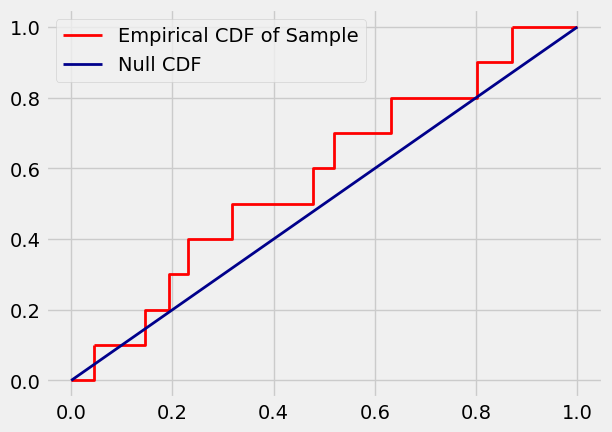

In [24]:
ks_plot([0, 1], stats.uniform.rvs(size = 10), stats.uniform.cdf)

Now increase the sample size to 100. What do you observe?

In [25]:
# Part (a)
...

*Your answer here.*

**(b)** The file `unknown_sample.npy` contains a sample drawn from an unknown cdf. We will test whether the sample is drawn from the uniform distribution or some other distribution. 

**(i)** Load the sample and plot its empirical cdf as well as the uniform $(0, 1)$ cdf.

In [26]:
# Part (b)(i)
unknown_sample = np.load('unknown_sample.npy')
...

Ellipsis

**(ii)** Estimate the Kolmogorov-Smirnov distance by eye. If you perform the Kolmogorov-Smirnov test of whether or not the sample `unknown_sample` is drawn from the uniform $(0, 1)$ distribution, should the $p$ value be large or small? Explain.

*Your answer here.*

**(c)** Let's do the test.

In general, the data $X_1, X_2, \ldots, X_n$ are assumed to be i.i.d. with cdf $F_X$. We test the two hypotheses:

- $H_0$: $F_X = F$ where $F$ is a specified cdf.
- $H_1$: $F_X \neq F$.

To perform the test, use the `stats` function `kstest`. It takes two arguments:

- `rvs`: the sample
- `cdf`: a callable that specifies the null cdf

Run the cell below to test whether your sample `unknown_sample` is drawn from the uniform $(0, 1)$ distribution. The results should be self-explanatory.


In [ ]:
stats.kstest(unknown_sample, stats.uniform.cdf)

Is the value of the statistic fairly close to what you estimated by eye? Is the $p$ value consistent with your answer to Part **(b)(ii)**?

*Your answer here.*

\newpage
## 4. Test for a Gamma Distribution

Now you'll give the Kolmogorov-Smirnov test more of a workout. The goal is to test whether data come from the gamma $(2, 1)$ distribution. 

**(a)** We'll start by defining the null cdf.

**(i)** Complete the function `gamma_2_1_cdf` below which takes an array `x` and returns the gamma $(2, 1)$ cdf at `x`. It's fine to assume that all the elements of `x` are positive.

Keep in mind that in the `stats.gamma` functions, the option for the shape parameter is called `a`. The `scale` parameter is $1/\lambda$ where $\lambda$ is the rate.

In [ ]:
# Part (a)
def gamma_2_1_cdf(x):
    return ...

**(ii)** To help decide a good interval over which to draw the plots, find the following for a random variable $X$ that has the gamma $(2, 1)$ distribution:

- $E(X)$
- $SD(X)$

Use these values to choose a plotting interval for the plots you'll make later in this question. You might have to come back later and adjust the right end point. That's fine.

In [ ]:
# Calculations for Part (a)(ii)
...

*Your answer here.*

**(b)** We'll use data $X_1, \ldots, X_n$ which are actually exponentially distributed.

**(i)** Generate an array `expon_1_sample` consisting of 20 i.i.d. exponential $(1)$ observations.

In [ ]:
# Part (b)(i)
np.random.seed(188)
expon_1_sample = ...

**(ii)** Plot the empirical cdf of `expon_1_sample` and the gamma $(2, 1)$ cdf. Is one of the two distributions stochastically smaller than the other? If so, which one, and why?

In [ ]:
# Part (b)(ii)
...

*Your answer here.*

**(iii)** Should the $p$ value be large or small? Explain.

*Your answer here.*

**(c)** Perform the Kolmogorov-Smirnov test of whether or not `expon_1_sample` is drawn from the gamma $(2, 1)$ distribution. Is the $p$ value consistent with your answer to **(b)(iii)**?

In [ ]:
# Part (c)
...

*Your answer here.*

\newpage
## 5. A Closer Call
The test in Exercise 4 is still a bit silly because the exponential $(1)$ distribution has a mean of $1$ unlike the gamma $(2, 1)$ distribution. Let's see what happens when the sample comes from an exponential distribution with the same mean as the gamma $(2, 1)$ distribution.

**(a)** Generate an array `expon_new_20` consisting of 20 i.i.d. observations from an exponential distribution with the same mean as the gamma $(2, 1)$.

In [ ]:
# Part (a)
np.random.seed(188)
expon_new_20 = ...

**(b)** Plot the empiricial cdf of `expon_new_20` and the gamma $(2, 1)$ cdf. Based on your graph, do you think the Kolmogorov-Smirnov test will be able to reach the correct conclusion? 

In [ ]:
# Part (b)
...

*Your answer here.*

**(c)** Perform the test of whether or not `expon_new_20` is drawn from the gamma $(2, 1)$ distribution. What does the test conclude?

In [ ]:
# Part (c)
...

*Your answer here.*

**(d)** In this part we'll look at what happens if we have more data. 

**(i)** Generate an array `expon_new_200` consisting of 200 i.i.d. observations from the same distribution as `expon_new_20`.

In [ ]:
# Part (d)(i)
np.random.seed(188)
expon_new_200 = ...

**(ii)** Plot the empirical distribution of `expon_new_200` and the gamma $(2, 1)$ cdf. Based on your graph, do you think the Kolmogorov-Smirnov test will be able to reach the correct conclusion? 

In [ ]:
# Part (d)(ii)
...

*Your answer here.*

**(iii)** Perform the test of whether or not `expon_new_200` is drawn from the gamma $(2, 1)$ distribution. What does the test conclude?

In [ ]:
# Part (d)(iii)
...

*Your answer here.*

\newpage
## 6. Simulating the Kolmogorov-Smirnov Distance
In this exercise, we'll revisit Exercise 3. As a reminder, we have data $X_1, \ldots, X_{10}$ (stored in `unknown_sample`) which are assumed to be i.i.d. with cdf $F_X$. We wish to test the following hypotheses:
- $H_0$: $F_X = F_U$, for $F_U$ the cdf of the uniform $(0, 1)$ distribution.
- $H_1$: $F_X \neq F_U$.

In Exercise 3, we used the `stats` function `kstest` to compute the $p$ value of our test. In this exercise, we'll instead compute the $p$ value by simulating the distribution of the Kolmogorov-Smirnov distance (which is related to the [Kolmogorov distribution](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#Kolmogorov_distribution)).

**(a)** The function `get_empirical_cdf` takes in an argument `sample` and returns the empirical cdf of the sample. Recall that the empirical cdf of a sample $X_1, \ldots, X_n$ is given by 
$$F_n(x) = \frac{1}{n} \sum_{i=1}^n I(X_i \le x).$$
The code below generates a sample, uses `get_empirical_cdf` to get the sample's empirical cdf, and then computes the Kolmogorov-Smirnov distance between the null cdf $F_U$ and the empirical cdf $F_n$ by searching over the possible values.

Run the cell below many times. What do you observe? How can we characterize the location (in particular the possible value) where the Kolmogorov-Smirnov distance is maximized?

n = 10


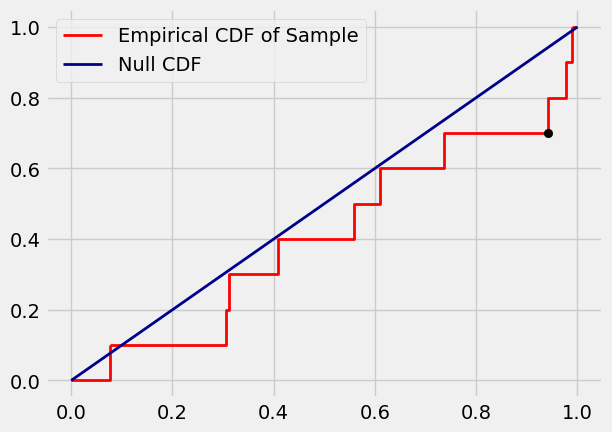

In [76]:
# Generate a sample and get its empirical cdf.
sample = stats.uniform.rvs(size = 10)
sample_ecdf = get_empirical_cdf(sample)

# Approximate the value at which the Kolmogorov-Smirnov distance is maximized by 
# searching over the possible values.
xs = np.linspace(0, 1, 1001)
distances = abs(sample_ecdf(xs) - stats.uniform.cdf(xs))
x_max = xs[np.argmax(distances)]
y_max = sample_ecdf(x_max)

# Plot the empirical cdf, the null cdf, and the point at which the 
# Kolmogorov-Smirnov distance is maximized.
ks_plot([0, 1], sample, stats.uniform.cdf)
plt.scatter(x_max, y_max, zorder = 2, c = 'k')

*Your answer here.*

**(b)** Let's compute the observed Kolmogorov-Smirnov distance of the sample `unknown_sample` from Exercise 3.

**(i)** Use `get_empirical_cdf` to assign `empirical_cdf` to the empirical cdf of the `unknown_sample` sample.

In [28]:
# Part (b)(i)
empirical_cdf = get_empirical_cdf(unknown_sample)

**(ii)** Use your observation from Part **(a)** to compute the observed Kolmogorov-Smirnov distance of `unknown_sample` *exactly*. Unlike the search computation from Part **(a)**, your calculation should be exact. You may use as many lines as you need.

In [29]:
# Part (b)(ii)
ordered_sample = np.sort(unknown_sample)
off_sample = np.append(0, ordered_sample[:-1])

F = stats.uniform.cdf(ordered_sample)
F_hat_upper = empirical_cdf(ordered_sample)
F_hat_lower = empirical_cdf(off_sample)

upper = abs(F - F_hat_upper)
lower = abs(F - F_hat_lower)
observed_KS_distance = max(max(upper), max(lower))

**(c)** Complete the function `one_null_KS_distance` which simulates one draw from the distribution of the Kolmogorov-Smirnov distance under the null hypothesis. As in Part **(b)**, your calculations should be exact.



In [30]:
# Part (c)
def one_null_KS_distance():
    sample = stats.uniform.rvs(size = 10)
    empirical_cdf = get_empirical_cdf(sample)

    ordered_sample = np.sort(sample)
    off_sample = np.append(0, ordered_sample[:-1])

    F = stats.uniform.cdf(ordered_sample)
    F_hat_lower = empirical_cdf(ordered_sample)
    F_hat_upper = empirical_cdf(off_sample)

    upper = abs(F - F_hat_upper)
    lower = abs(F - F_hat_lower)
    return max(max(upper), max(lower))

**(d)** Use your function from Part **(c)** to simulate 50,000 draws from the distribution of the Kolmogorov-Smirnov distance under the null hypothesis. Draw the empirical histogram of all the simulated values.

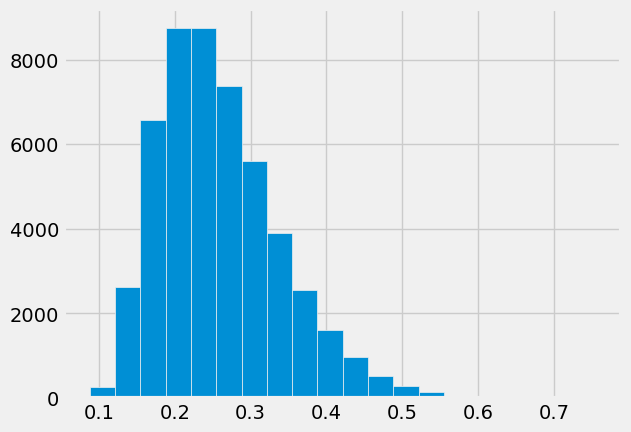

In [31]:
# Part (d)
np.random.seed(188)
null_KS_distances = np.zeros(50000)
for i in range(50000):
    null_KS_distances[i] = one_null_KS_distance()

plt.hist(null_KS_distances, bins = 20);

**(e)** Approximate the $p$ value of the Kolmogorov-Smirnov test. Compare it with the $p$ value computed using the `kstest` function in Exercise 3.

In [32]:
# Part (e)
np.mean(null_KS_distances >= observed_KS_distance)

0.89185999999999999

*Your answer here.*